In [62]:
import pandas as pd
from nilearn.interfaces.bids import get_bids_files
from tqdm import tqdm
import numpy as np

In [63]:
confound_files = get_bids_files(
    'data/julia2018/derivatives/fmriprep_2020',
    # file_tag='timeseries',
    modality_folder='func',
    filters=[('ses', 'rest'), ('desc', 'confounds')],
    file_type='tsv')

_confounds_lst = []

for confound_file in confound_files:
    df = pd.read_csv(confound_file, sep='\t')
    df['subject'] = confound_file.split('/')[4].replace('sub-','')
    df['group'] = df['subject'].apply(lambda x: x[:4])
    _confounds_lst.append(df)

confounds = pd.concat(_confounds_lst).reset_index(drop=True)

y = confounds.pop('group')

subjects = confounds.pop('subject')
X = confounds.dropna(axis=1)

In [64]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('zv', VarianceThreshold(0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('clf', SVC(kernel='linear', probability=True))
])

param_grid = {
    
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

In [65]:
# hyper-parameter optimization
grid.fit(X, y)
model = grid.best_estimator_

# cross-validated model fitting
scores = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    model.fit(X.iloc[train], y.iloc[train])
    score = model.score(X.iloc[test], y.iloc[test])
    scores.append(score)

print(f'score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.499 total time=   2.2s
[CV 2/5] END ..................................., score=0.396 total time=   2.3s
[CV 3/5] END ..................................., score=0.594 total time=   2.5s
[CV 5/5] END ..................................., score=0.507 total time=   2.6s
[CV 4/5] END ..................................., score=0.684 total time=   2.6s


100%|██████████| 50/50 [01:58<00:00,  2.36s/it]

score (mean/std): 0.767/0.015


In [101]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

chance_model = DummyClassifier(strategy='most_frequent')

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    chance_model.fit(X.iloc[train], y.iloc[train])
    y_pred = chance_model.predict(X.iloc[test])
    score = accuracy_score(y.iloc[test], y_pred)
    scores.append(score)

print(f'chance score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

100%|██████████| 50/50 [00:00<00:00, 203.42it/s]

chance score (mean/std): 0.518/0.055


In [104]:
from sklearn.inspection import permutation_importance

perm_results = permutation_importance(model, X, y, scoring='accuracy')

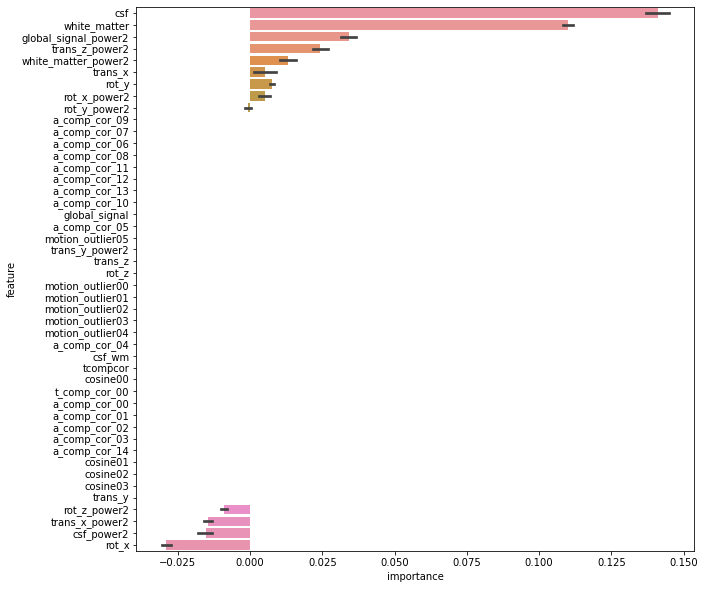

In [133]:
perm_results_df = pd.DataFrame(perm_results.importances, index=X.columns)

perm_results_df = perm_results_df.reset_index().rename(columns={'index':'feature'})
perm_results_df = perm_results_df.melt(
    id_vars=['feature'],
    var_name='cv_repetition',
    value_name='importance')
perm_results_df = perm_results_df.sort_values(by='importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10,10))
sns.barplot(data=perm_results_df, x='importance', y='feature', orient='h', ax=ax)
plt.show()